In [131]:
import dgl
from dgl.data import DGLDataset
import torch
import os
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score, average_precision_score
from sklearn.utils import class_weight
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import dgl.function as fn
from ignite.metrics.recall import Recall

import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import random
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

In [132]:
class AMLDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='AMLDataset')

    def process(self):
        nodes_data = pd.read_csv (r"C:\Users\ricka\Documents\data\done\accounts_redone_anon3.csv")
        edges_data = pd.read_csv (r"C:\Users\ricka\Documents\data\done\transactions_redone_anon3.csv")
        
        sc = preprocessing.StandardScaler()
        #nodes_data["acct_id"] = sc.fit_transform(np.array(nodes_data["acct_id"]).reshape(-1, 1))
        nodes_data["initial_deposit"] = sc.fit_transform(np.array(nodes_data["initial_deposit"]).reshape(-1, 1))
        nodes_data["in_amt_mean"] = sc.fit_transform(np.array(nodes_data["in_amt_mean"]).reshape(-1, 1))
        nodes_data["in_amt_var"] = sc.fit_transform(np.array(nodes_data["in_amt_var"]).reshape(-1, 1))
        nodes_data["out_amt_mean"] = sc.fit_transform(np.array(nodes_data["out_amt_mean"]).reshape(-1, 1))
        nodes_data["out_amt_var"] = sc.fit_transform(np.array(nodes_data["out_amt_var"]).reshape(-1, 1))
        nodes_data["out-going_trans"] = sc.fit_transform(np.array(nodes_data["out-going_trans"]).reshape(-1, 1))
        nodes_data["in-going_trans"] = sc.fit_transform(np.array(nodes_data["in-going_trans"]).reshape(-1, 1))
        nodes_data["unique_out-going_trans"] = sc.fit_transform(np.array(nodes_data["unique_out-going_trans"]).reshape(-1, 1))
        nodes_data["unique_in-going_trans"] = sc.fit_transform(np.array(nodes_data["unique_in-going_trans"]).reshape(-1, 1))
        
        #node_features = torch.from_numpy(np.array([nodes_data["acct_id"]]).transpose())
        node_features = torch.from_numpy(np.array([nodes_data["initial_deposit"],
                nodes_data["in_amt_mean"], nodes_data["in_amt_var"], nodes_data["out_amt_mean"],
                nodes_data["out_amt_var"], nodes_data["out-going_trans"], nodes_data["in-going_trans"],
                nodes_data["unique_in-going_trans"], nodes_data["unique_out-going_trans"]]).transpose())
        """
        node_features = torch.from_numpy(np.array([nodes_data["initial_deposit"], nodes_data["acct_id"],
                        nodes_data["in_amt_mean"], nodes_data["in_amt_var"], nodes_data["out_amt_mean"],
                        nodes_data["out_amt_var"], nodes_data["out-going_trans"], nodes_data["in-going_trans"],
                        nodes_data["unique_in-going_trans"], nodes_data["unique_out-going_trans"]]).transpose())
        """
        
        node_labels = torch.from_numpy(nodes_data["prior_sar_count"].to_numpy()*1).type(torch.LongTensor)
        le = preprocessing.LabelEncoder()
        edges_data["tran_timestamp"] = le.fit_transform(edges_data["tran_timestamp"].astype("str"))
        #edges_data["is_sar"] = edges_data["is_sar"].apply(lambda x: 1 if x == True else -1)
        edges_data["is_sar"] = edges_data["is_sar"]*1
        
        edges_data["base_amt"] = sc.fit_transform(np.array(edges_data["base_amt"]).reshape(-1, 1))
        #edges_data["tran_id"] = sc.fit_transform(np.array(edges_data["tran_id"]).reshape(-1, 1))
        edges_data["tran_timestamp"] = sc.fit_transform(np.array(edges_data["tran_timestamp"]).reshape(-1, 1))
        edges_data["orig_amt_before"] = sc.fit_transform(np.array(edges_data["orig_amt_before"]).reshape(-1, 1))
        edges_data["orig_amt_after"] = sc.fit_transform(np.array(edges_data["orig_amt_after"]).reshape(-1, 1))
        edges_data["bene_amt_before"] = sc.fit_transform(np.array(edges_data["bene_amt_before"]).reshape(-1, 1))
        edges_data["bene_amt_after"] = sc.fit_transform(np.array(edges_data["bene_amt_after"]).reshape(-1, 1))
        
        """
        edge_features = torch.from_numpy(np.array([edges_data["tran_id"], edges_data["base_amt"],
                        edges_data["tran_timestamp"], edges_data["orig_amt_before"], edges_data["orig_amt_after"],
                        edges_data["bene_amt_before"], edges_data["bene_amt_after"]]).transpose())
        """
        
        edge_features = torch.from_numpy(np.array([edges_data["base_amt"],
                        edges_data["tran_timestamp"], edges_data["orig_amt_before"], edges_data["orig_amt_after"],
                        edges_data["bene_amt_before"], edges_data["bene_amt_after"]]).transpose())        
        #edge_features = torch.from_numpy(np.array([edges_data["tran_id"], edges_data["base_amt"], edges_data["tran_timestamp"],
                                                   #edges_data["is_sar"], edges_data["alert_id"]]).transpose())
        edges_src = torch.from_numpy(edges_data['orig_acct'].to_numpy())
        edges_dst = torch.from_numpy(edges_data['bene_acct'].to_numpy())

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=nodes_data.shape[0])
        self.graph.ndata['node_feat'] = node_features
        self.graph.ndata['label'] = node_labels
        self.graph.edata['edge_feat'] = edge_features

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        n_nodes = nodes_data.shape[0]
        n_train = int(n_nodes * 0.6) 
        n_val = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train:n_train + n_val] = True
        test_mask[n_train + n_val:] = True
        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask
        self.graph.ndata['test_mask'] = test_mask

    def __getitem__(self, i):                     
        return self.graph

    def __len__(self):
        return 1

dataset = AMLDataset()
g = dataset[0]
#g = dgl.add_self_loop(g)
g = g.to('cuda')

In [133]:
class GNNLayer2(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(GNNLayer2, self).__init__()
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        self.W_apply = nn.Linear(ndim_out + ndim_in, ndim_out)
        self.activation = activation
        
    def message_func(self, edges):
        return {'m': F.relu(self.W_msg(torch.cat([edges.src['h'].float(),
                                                  edges.data['h'].float()], 1)))}
    
    def forward(self, g, nfeats, efeats):
        with g.local_scope():
            g.ndata["h"] = nfeats
            g.edata["h"] = efeats
            g.update_all(self.message_func, fn.sum('m', 'h_neigh'))
            g.ndata['h'] = F.relu(self.W_apply(torch.cat([g.ndata['h'].float(),
                                                          g.ndata['h_neigh'].float()], 1)))
            return g.ndata['h']

class GCN2(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(GCN2, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(GNNLayer2(ndim_in, edim, 60, activation))
        #self.layers.append(GNNLayer2(35, edim, 35, activation))
        self.layers.append(GNNLayer2(60, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)
    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        n = nfeats
        #n = nfeats.sum(1)
        return n 

In [134]:
ndim_in = 9
ndim_out = 2 #num_classes
edim = 6
dropout = 0
model = GCN2(ndim_in, ndim_out, edim, F.relu, dropout).to("cuda")
#model = GCN2(ndim_in, ndim_out, edim, F.relu, dropout)
nfeats = g.ndata["node_feat"]
efeats = g.edata["edge_feat"]

#one_hot_labels = F.one_hot(g.ndata["label"]).float()

#bygg träningsloopen
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
labels = g.ndata["label"].cpu().numpy()
#weights = class_weight.compute_class_weight('balanced', np.unique(labels), labels)
weights = np.array([1, 40])
weights = torch.from_numpy(weights).float().to("cuda")

loss_history = []
loss_val_history = []
r_history = []
r_val_history = []
p_history = []
p_val_history = []
model.train()
total = 300

def recall(y_pred, labels):
    y_pred = y_pred.cpu()
    la = labels.cpu()
    return torch.tensor(recall_score(la,y_pred))

def precision(y_pred, labels):
    y_pred = y_pred.cpu()
    la = labels.cpu()
    return torch.tensor(precision_score(la, y_pred))

for epoch in range(total):
    optimizer.zero_grad()
    out = model(g, nfeats, efeats)
    loss = F.cross_entropy(out[g.ndata["train_mask"]], g.ndata["label"][g.ndata["train_mask"]], weight=weights)
    loss.backward()
    optimizer.step()
    
    loss_val = F.cross_entropy(out[g.ndata["val_mask"]], g.ndata["label"][g.ndata["val_mask"]], weight=weights)
    running_loss_val = loss_val.item()
    loss_val_history.append(running_loss_val)
    
    running_loss = loss.item()
    loss_history.append(running_loss)
    
    _, y_pred = out.max(dim=1)
    r = recall(y_pred[g.ndata["train_mask"]], g.ndata["label"][g.ndata["train_mask"]])
    r_val = recall(y_pred[g.ndata["val_mask"]], g.ndata["label"][g.ndata["val_mask"]])
    r_history.append(r)
    r_val_history.append(r_val)
    
    p = precision(y_pred[g.ndata["train_mask"]], g.ndata["label"][g.ndata["train_mask"]])
    p_val = precision(y_pred[g.ndata["val_mask"]], g.ndata["label"][g.ndata["val_mask"]])
    p_history.append(p)
    p_val_history.append(p_val)
    
    if (epoch % 20 == 0):
        print(epoch)

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280


Accuracy: 0.9900
Average precision-recall score: 0.72
[[3856   37]
 [   3  104]]


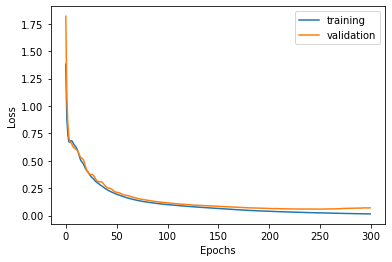

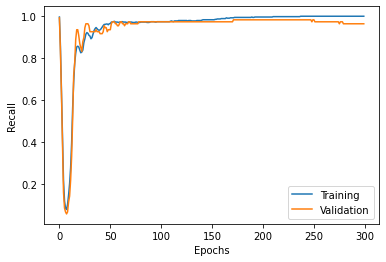

Text(0, 0.5, 'Precision')

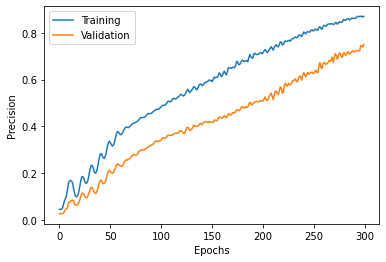

In [135]:
model.eval()
#_, pred = model(g, nfeats, efeats).max(dim=1)
_, pred = F.softmax(model(g, nfeats, efeats), dim=1).max(dim=1)

correct = int(pred[g.ndata["test_mask"]].eq(g.ndata["label"][g.ndata["test_mask"]]).sum().item())
y_test = g.ndata["label"][g.ndata["test_mask"]].cpu()
y_true = pred[g.ndata["test_mask"]].cpu()
average_precision = average_precision_score(y_test, y_true)
acc = correct / len(g.ndata["label"][g.ndata["test_mask"]])
print('Accuracy: {:.4f}'.format(acc))
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
print(confusion_matrix(g.ndata["label"][g.ndata["test_mask"]].cpu(), pred[g.ndata["test_mask"]].cpu().detach()))
training = plt.plot(list(range(total)), loss_history, label="training")
validation = plt.plot(list(range(total)), loss_val_history, label="validation")
plt.legend(handles=[training[0], validation[0]])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
plt.plot(list(range(total)), r_history)
plt.plot(list(range(total)), r_val_history)
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.show()
plt.plot(list(range(total)), p_history)
plt.plot(list(range(total)), p_val_history)
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Precision")

In [136]:
#Threshold
"""
p = F.softmax(model(g, nfeats, efeats),dim=1)[:,1]

alpha = [0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
fp = np.zeros(len(alpha))
fn = np.zeros(len(alpha))

for i in range(len(alpha)):
    pr = (p>alpha[i]).float()
    cm = confusion_matrix(g.ndata["label"][g.ndata["test_mask"]].cpu(), pr[g.ndata["test_mask"]].cpu())
    fp[i] = cm[0, 1]
    fn[i] = cm[1, 0]
#print(confusion_matrix(g.ndata["label"][g.ndata["test_mask"]].cpu(), pr[g.ndata["test_mask"]].cpu()))
plt.plot(alpha, fp)
plt.plot(alpha, fn)
plt.xlabel("Threshold")
plt.ylabel("Number of Miss-classifications")
plt.legend(["False Positives", "False Negatives"])
plt.show()
"""

'\np = F.softmax(model(g, nfeats, efeats),dim=1)[:,1]\n\nalpha = [0.6, 0.5, 0.4, 0.3, 0.2, 0.1]\nfp = np.zeros(len(alpha))\nfn = np.zeros(len(alpha))\n\nfor i in range(len(alpha)):\n    pr = (p>alpha[i]).float()\n    cm = confusion_matrix(g.ndata["label"][g.ndata["test_mask"]].cpu(), pr[g.ndata["test_mask"]].cpu())\n    fp[i] = cm[0, 1]\n    fn[i] = cm[1, 0]\n#print(confusion_matrix(g.ndata["label"][g.ndata["test_mask"]].cpu(), pr[g.ndata["test_mask"]].cpu()))\nplt.plot(alpha, fp)\nplt.plot(alpha, fn)\nplt.xlabel("Threshold")\nplt.ylabel("Number of Miss-classifications")\nplt.legend(["False Positives", "False Negatives"])\nplt.show()\n'

In [137]:
#exploring weights
"""
we = [8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68]
w = range(8, 72, 4)
f_p = [14, 8, 13, 15, 10, 10, 10, 11, 10, 10, 12, 12, 13, 13, 14, 13]
f_n = [6, 5, 6, 5, 6, 4, 4, 4, 3, 3, 3, 4, 3, 4, 3, 3]
FP = plt.plot(w, f_p, label="False Positives")
FN = plt.plot(w, f_n, label="False Negatives")
EX = plt.plot([25.56,25.56], [0,15], color="r", label="Proposed Ratio")
plt.xlabel("Weight Ratio")
plt.ylabel("Number of Miss-classifications")
plt.legend(handles=[FP[0], FN[0], EX[0]])
"""

'\nwe = [8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68]\nw = range(8, 72, 4)\nf_p = [14, 8, 13, 15, 10, 10, 10, 11, 10, 10, 12, 12, 13, 13, 14, 13]\nf_n = [6, 5, 6, 5, 6, 4, 4, 4, 3, 3, 3, 4, 3, 4, 3, 3]\nFP = plt.plot(w, f_p, label="False Positives")\nFN = plt.plot(w, f_n, label="False Negatives")\nEX = plt.plot([25.56,25.56], [0,15], color="r", label="Proposed Ratio")\nplt.xlabel("Weight Ratio")\nplt.ylabel("Number of Miss-classifications")\nplt.legend(handles=[FP[0], FN[0], EX[0]])\n'

In [138]:
#exploring layer size
"""
we = [8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68]
w = range(10, 75, 5)
f_p = [44, 15, 15, 0, 25, 0, 9, 0, 13, 8, 10, 13, 0]
f_n = [7, 7, 3, 107, 25, 107, 4, 107, 5, 7, 4, 8, 107]
FP = plt.plot(w, f_p, label="False Positives")
FN = plt.plot(w, f_n, label="False Negatives")
plt.xlabel("Layer Size")
plt.ylabel("Number of Miss-classifications")
plt.legend(handles=[FP[0], FN[0]])
plt.show()
#remove non conv
w = [10, 15, 20, 30, 40, 50, 55, 60, 65]
f_p = [44, 15, 15, 25, 9, 13, 8, 10, 13]
f_n = [7, 7, 3, 25, 4, 5, 7, 4, 8]
FP = plt.plot(w, f_p, label="False Positives")
FN = plt.plot(w, f_n, label="False Negatives")
plt.xlabel("Layer Size")
plt.ylabel("Number of Miss-classifications")
plt.legend(handles=[FP[0], FN[0]])
"""

'\nwe = [8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68]\nw = range(10, 75, 5)\nf_p = [44, 15, 15, 0, 25, 0, 9, 0, 13, 8, 10, 13, 0]\nf_n = [7, 7, 3, 107, 25, 107, 4, 107, 5, 7, 4, 8, 107]\nFP = plt.plot(w, f_p, label="False Positives")\nFN = plt.plot(w, f_n, label="False Negatives")\nplt.xlabel("Layer Size")\nplt.ylabel("Number of Miss-classifications")\nplt.legend(handles=[FP[0], FN[0]])\nplt.show()\n#remove non conv\nw = [10, 15, 20, 30, 40, 50, 55, 60, 65]\nf_p = [44, 15, 15, 25, 9, 13, 8, 10, 13]\nf_n = [7, 7, 3, 25, 4, 5, 7, 4, 8]\nFP = plt.plot(w, f_p, label="False Positives")\nFN = plt.plot(w, f_n, label="False Negatives")\nplt.xlabel("Layer Size")\nplt.ylabel("Number of Miss-classifications")\nplt.legend(handles=[FP[0], FN[0]])\n'

In [139]:
#learning rate
"""
we = [0.0001, 0.0005, 0.0010, 0.0015, 0.0020, 0.0025, 0.0030, 0.0035, 0.0040, 0.0045, 0.0050, 0.0055, 0.0060, 0.0065, 0.0070, 0.0075, 0.0080]
f_p = [422, 53, 17, 10, 6, 3, 14, 26, 25, 25, 3, 1, 12, 1, 20, 1, 0]
f_n = [20, 4, 5, 4, 4, 4, 2, 2, 2, 3, 2, 3, 2, 4, 2, 23, 107]
FP = plt.plot(we, f_p, label="False Positives")
FN = plt.plot(we, f_n, label="False Negatives")
plt.xlabel("Learning Rate")
plt.ylabel("Number of Miss-classifications")
axes = plt.gca()
axes.set_ylim([0,150])
plt.legend(handles=[FP[0], FN[0]])
"""

'\nwe = [0.0001, 0.0005, 0.0010, 0.0015, 0.0020, 0.0025, 0.0030, 0.0035, 0.0040, 0.0045, 0.0050, 0.0055, 0.0060, 0.0065, 0.0070, 0.0075, 0.0080]\nf_p = [422, 53, 17, 10, 6, 3, 14, 26, 25, 25, 3, 1, 12, 1, 20, 1, 0]\nf_n = [20, 4, 5, 4, 4, 4, 2, 2, 2, 3, 2, 3, 2, 4, 2, 23, 107]\nFP = plt.plot(we, f_p, label="False Positives")\nFN = plt.plot(we, f_n, label="False Negatives")\nplt.xlabel("Learning Rate")\nplt.ylabel("Number of Miss-classifications")\naxes = plt.gca()\naxes.set_ylim([0,150])\nplt.legend(handles=[FP[0], FN[0]])\n'

In [140]:
#dropout
"""
we = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
f_p = [10, 15, 21, 21, 26, 36, 48, 64]
f_n = [4, 4, 4, 5, 4, 4, 4, 5]
FP = plt.plot(we, f_p, label="False Positives")
FN = plt.plot(we, f_n, label="False Negatives")
plt.xlabel("Dropout")
plt.ylabel("Number of Miss-classifications")
plt.legend(handles=[FP[0], FN[0]])
"""

'\nwe = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]\nf_p = [10, 15, 21, 21, 26, 36, 48, 64]\nf_n = [4, 4, 4, 5, 4, 4, 4, 5]\nFP = plt.plot(we, f_p, label="False Positives")\nFN = plt.plot(we, f_n, label="False Negatives")\nplt.xlabel("Dropout")\nplt.ylabel("Number of Miss-classifications")\nplt.legend(handles=[FP[0], FN[0]])\n'

In [141]:
#t-SNE
"""
labels = g.edata["edge_feat"][:,2].detach().cpu().numpy()
labels = pd.DataFrame(labels)
labels["l"] = labels
del labels[0]
#idx = labels.index[labels["l"] == 1].values
true_labels = labels.loc[labels["l"] == 1]
false_labels = labels.loc[labels["l"] == 0]
false_labels_red = false_labels.sample(n=len(true_labels))
labels_red = pd.concat([true_labels, false_labels_red])

edges = torch.cat([g.edata["edge_feat"][:,0:2], g.edata["edge_feat"][:,3:8]], 1)
edges = edges.detach().cpu().numpy()
idx = labels_red.index.values
edges_red = edges[idx]
labels_red = np.array(labels_red)

trans = TSNE(n_components=2)
X_trans = trans.fit_transform(edges_red)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_trans[:, 0],
    X_trans[:, 1],
    c=labels_red,
    cmap="jet",
    alpha=0.7,)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title="Visualization of the edges in the data set",)
#plt.legend(["Non Fraudulent", "Fraudulent"])
#ax.legend(labels_red, ["Non Fraudulent", "Fraudulent"])
"""

'\nlabels = g.edata["edge_feat"][:,2].detach().cpu().numpy()\nlabels = pd.DataFrame(labels)\nlabels["l"] = labels\ndel labels[0]\n#idx = labels.index[labels["l"] == 1].values\ntrue_labels = labels.loc[labels["l"] == 1]\nfalse_labels = labels.loc[labels["l"] == 0]\nfalse_labels_red = false_labels.sample(n=len(true_labels))\nlabels_red = pd.concat([true_labels, false_labels_red])\n\nedges = torch.cat([g.edata["edge_feat"][:,0:2], g.edata["edge_feat"][:,3:8]], 1)\nedges = edges.detach().cpu().numpy()\nidx = labels_red.index.values\nedges_red = edges[idx]\nlabels_red = np.array(labels_red)\n\ntrans = TSNE(n_components=2)\nX_trans = trans.fit_transform(edges_red)\n\nfig, ax = plt.subplots(figsize=(7, 7))\nax.scatter(\n    X_trans[:, 0],\n    X_trans[:, 1],\n    c=labels_red,\n    cmap="jet",\n    alpha=0.7,)\nax.set(\n    aspect="equal",\n    xlabel="$X_1$",\n    ylabel="$X_2$",\n    title="Visualization of the edges in the data set",)\n#plt.legend(["Non Fraudulent", "Fraudulent"])\n#ax.leg

In [142]:
"""
labels = g.ndata["label"].detach().cpu().numpy()
labels = pd.DataFrame(labels)
labels["l"] = labels
del labels[0]
#idx = labels.index[labels["l"] == 1].values
true_labels = labels.loc[labels["l"] == 1]
false_labels = labels.loc[labels["l"] == 0]
false_labels_red = false_labels.sample(n=len(true_labels))
labels_red = pd.concat([true_labels, false_labels_red])

nodes = g.ndata["node_feat"].detach().cpu().numpy()
idx = labels_red.index.values
nodes_red = edges[idx]
labels_red = np.array(labels_red)

trans = TSNE(n_components=2)
X_trans = trans.fit_transform(nodes_red)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_trans[:, 0],
    X_trans[:, 1],
    c=labels_red,
    cmap="jet",
    alpha=0.7,)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title="Visualization of the nodes in the data set",)
"""

'\nlabels = g.ndata["label"].detach().cpu().numpy()\nlabels = pd.DataFrame(labels)\nlabels["l"] = labels\ndel labels[0]\n#idx = labels.index[labels["l"] == 1].values\ntrue_labels = labels.loc[labels["l"] == 1]\nfalse_labels = labels.loc[labels["l"] == 0]\nfalse_labels_red = false_labels.sample(n=len(true_labels))\nlabels_red = pd.concat([true_labels, false_labels_red])\n\nnodes = g.ndata["node_feat"].detach().cpu().numpy()\nidx = labels_red.index.values\nnodes_red = edges[idx]\nlabels_red = np.array(labels_red)\n\ntrans = TSNE(n_components=2)\nX_trans = trans.fit_transform(nodes_red)\n\nfig, ax = plt.subplots(figsize=(7, 7))\nax.scatter(\n    X_trans[:, 0],\n    X_trans[:, 1],\n    c=labels_red,\n    cmap="jet",\n    alpha=0.7,)\nax.set(\n    aspect="equal",\n    xlabel="$X_1$",\n    ylabel="$X_2$",\n    title="Visualization of the nodes in the data set",)\n'

In [143]:
#edges PaySim
"""
edges = pd.read_csv (r"C:\Users\ricka\Documents\synthetic_data.csv")
labels = edges["isFraud"]
true_labels = labels.loc[labels == 1]
false_labels = labels.loc[labels == 0]
false_labels_red = false_labels.sample(n=len(true_labels))
labels_red = pd.concat([true_labels, false_labels_red])

edges = edges.drop(["type", "nameOrig", "nameDest", "isFraud", "isFlaggedFraud"], axis=1)
idx = labels_red.index.values
edges_red = edges.iloc[idx]
labels_red = np.array(labels_red)

trans = TSNE(n_components=2)
X_trans = trans.fit_transform(edges_red)

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_trans[:, 0],
    X_trans[:, 1],
    c=labels_red,
    cmap="jet",
    alpha=0.7,)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title="Visualization of the edges in the data set",)
#plt.legend(["Non Fraudulent", "Fraudulent"])
#ax.legend(labels_red, ["Non Fraudulent", "Fraudulent"])
"""

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 26-27: truncated \UXXXXXXXX escape (<ipython-input-143-f63dc79ec841>, line 2)